## Mosaic the image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from colour_demosaicing import masks_CFA_Bayer

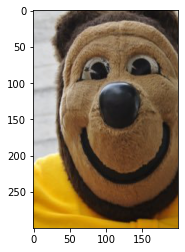

In [2]:
image = imread('image/oski.png', 'png')
shape = (300, 200)
start = (50, 50)
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :] # crop the image
plt.imshow(image)

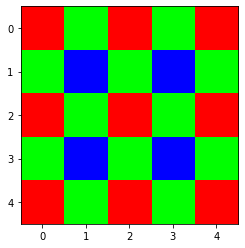

In [3]:
# construct the bayer pattern filter
bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
plt.imshow(bayer_filter[50:55, 50:55, :])

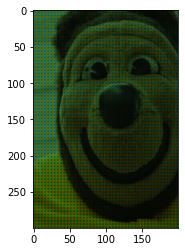

In [4]:
# mosaic the image by applying the Bayer CFA
mosaic_image = image * bayer_filter
plt.imshow(mosaic_image)

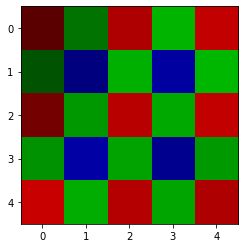

In [5]:
# compared the filtered image and the filter at the same area
plt.imshow(mosaic_image[50:55, 50:55])

**Observation:** There are positions of the mosaic image with zero values in all the channels. 

In [6]:
mosaic_image[299:, 155:160]

array([[[ 0.        ,  0.        ,  0.00392157],
        [ 0.        ,  0.51372552,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.52156866,  0.        ],
        [ 0.        ,  0.        ,  0.01176471]]])

All of the entries in row 3 are zero.

In [7]:
image[299:, 155:160]

array([[[ 0.8039216 ,  0.5176471 ,  0.00392157],
        [ 0.8039216 ,  0.5137255 ,  0.        ],
        [ 0.8117647 ,  0.50980395,  0.        ],
        [ 0.79607844,  0.52156866,  0.00392157],
        [ 0.7921569 ,  0.52156866,  0.01176471]]], dtype=float32)

In [8]:
bayer_filter[299:, 155:160]

array([[[ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]]])

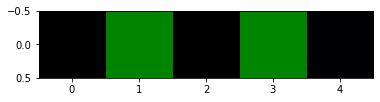

In [9]:
plt.imshow(mosaic_image[299:, 155:160])

## Building the algorithm

### Original

Below is the alternating maximization oracle which is bacially the original alternating minimization orcale with a few changes.

In [27]:
# Alternating maximization oracle
def altmax(r, lpar, p, tol, cmax, gap, c, the_q, Un):
    the = the_q.copy()
    cum_r = np.insert(np.cumsum(r), 0, 0)
    un = Un.shape[0]

    last_cmax = cmax - 1e6
    cnt = 0
    while (True):
        cnt += 1
        for ind in range(p):
            pro = lpar*c.copy()
            for k in range(p):
                if (ind != k):
                    pro = np.multiply(pro, the[cum_r[k] + Un[:,k]]) 

            fpro = np.zeros(r[ind])
            for k in range(un):
                fpro[Un[k,ind]] += pro[k]
            the[cum_r[ind]:cum_r[ind+1]] = (fpro >= 0).astype(int)
            curr_cmax = np.sum(fpro[fpro >= 0])

        if (curr_cmax < last_cmax + tol):
            break
        else:
            last_cmax = curr_cmax

    psi = np.ones(un)
    for k in range(p):
        psi = np.multiply(psi, the[cum_r[k] + Un[:,k]])

    return(psi, the, curr_cmax)

In [28]:
r = image.shape
p = len(r)
lpar = 1
tol = 1e-4
cmax = -float('inf')

# with projection on U
Un = np.argwhere(bayer_filter == 1)
# # without projection on U
# Un = np.arange(np.prod(r)) 
# Un = np.unravel_index(Un, r)
# Un = np.vstack(Un).T

un = len(Un)

mu = []
N_t = 0

# with projection on U
psi_t = np.zeros(un)
# # without projection on U
# psi_t = np.zeros(np.prod(image.shape))

the = np.round(np.random.uniform(0,1,np.sum(r)))

# with projection on U
p_t = mosaic_image.flatten()[bayer_filter.flatten() == 1]
# # without projection on U
# p_t = mosaic_image.flatten()

q_ts = []

cnt = 0

In [29]:
# while (N_t <= lpar):
#     cnt += 1
#     q_t, the_t, _ = altmax(r, lpar, p, tol, cmax, None, p_t, the, Un)
#     mu_t = np.min((p_t / q_t)[q_t > 0])
#     mu.append(mu_t)
#     p_t = p_t - mu_t * q_t
#     psi_t = psi_t + mu_t * q_t
#     N_t = N_t + mu_t
#     print(q_t.sum())
#     if cnt == 20:
#         break

**Observation**: All the entries of the alternating maximization solution, $q_t$, are always 1. I think it is because $c$ which is $p_t$ here is nonnegative, so trivially the solution always has all the entries being 1.

**Observation**: The $\mu$'s are all zeros. I think this is because some entries of $p_t$ are zero, as we saw before, $mu$ has to be zero to satisfy the nonnegativity constraint.

### Solution
Set the entries of $q_t$ where the corresponding $p_t$ is zero to zero. The following is the updated algorithm

In [30]:
r = image.shape
p = len(r)
lpar = 1
tol = 1e-4
cmax = -float('inf')

# with projection on U
Un = np.argwhere(bayer_filter == 1)
# # without projection on U
# Un = np.arange(np.prod(r)) 
# Un = np.unravel_index(Un, r)
# Un = np.vstack(Un).T

un = len(Un)

mu = []
N_t = 0

# with projection on U
psi_t = np.zeros(un)
# # without projection on U
# psi_t = np.zeros(np.prod(image.shape))

# with projection on U
p_t = mosaic_image.flatten()[bayer_filter.flatten() == 1]
# # without projection on U
# p_t = mosaic_image.flatten()

q_ts = []

cnt = 0

In [31]:
while (N_t <= lpar):
    cnt += 1
    the = np.round(np.random.uniform(0,1,np.sum(r)))
    q_t, the_t, _ = altmax(r, lpar, p, tol, cmax, None, p_t, the, Un)
    q_t[p_t == 0] = 0 # CHANGE
    q_ts.append(q_t)
    # the_t[TODO] = 0 
    mu_t = np.min((p_t / q_t)[q_t > 0])
    mu.append(mu_t)
    p_t = p_t - mu_t * q_t
    psi_t = psi_t + mu_t * q_t
    N_t = N_t + mu_t

    if p_t.sum() == 0: # the tensor has been fully decomposed
        break

C:\Users\Wenhao\AppData\Local\Temp\ipykernel_21524\2440312554.py:8: RuntimeWarning: invalid value encountered in true_divide
  mu_t = np.min((p_t / q_t)[q_t > 0])


$\psi_t$ is exactly the same as the demosic image!

In [32]:
np.all((mosaic_image.flatten()[bayer_filter.flatten() == 1] == psi_t))

True

## Modularizing the algorithm

Below I updated the alternating maximization oracle by making it solved only over $\mathcal{C}_1$. Then, we multiply the solution with the `lpar`, $\lambda$.

In [10]:
# alternating maximization oracle
def altmax(r, p, tol, cmax, c, the_q, Un):
    the = the_q.copy()
    cum_r = np.insert(np.cumsum(r), 0, 0)
    un = Un.shape[0]

    last_cmax = cmax - 1e6
    cnt = 0
    while (True):
        cnt += 1
        for ind in range(p):
            pro = c.copy()
            for k in range(p):
                if (ind != k):
                    pro = np.multiply(pro, the[cum_r[k] + Un[:,k]]) 

            fpro = np.zeros(r[ind])
            for k in range(un):
                fpro[Un[k,ind]] += pro[k]
            the[cum_r[ind]:cum_r[ind+1]] = (fpro >= 0).astype(int)
            curr_cmax = np.sum(fpro[fpro >= 0])

        if (curr_cmax < last_cmax + tol):
            break
        else:
            last_cmax = curr_cmax

    psi = np.ones(un)
    for k in range(p):
        psi = np.multiply(psi, the[cum_r[k] + Un[:,k]])

    return(psi, the, curr_cmax)

def heuristic(p_0, filter, proj=False, lpar=1, tol=1e-4):
    """
    Deflate/decompose the tensor p_0 of the mosaic image
    ---
    Arguments:
    p_0 (np.array): the mosaic image
    filter (np.array): the filter used to mosaic the image
    proj (bool): working in proj_U(C_lpar) if True
    lpar (scalar): the lambda parameter
    tol (scalar): the tolarance used in the alternating maximization

    Returns:
    psi_t (np.array): the flatten version
    Psi_t (np.array): the original version
    mu (list[scalar]): a list of mu_t
    q (list[np.array]): a list of q_t
    """

    # initializing parameters
    r = p_0.shape
    p = len(r)
    cmax = -float('inf')
    if proj:
        Un = np.argwhere(filter == 1)      
        p_t = p_0.flatten()[bayer_filter.flatten() == 1]
    else:
        Un = np.arange(np.prod(r)) 
        Un = np.unravel_index(Un, r)
        Un = np.vstack(Un).T
        p_t = mosaic_image.flatten()
    un = len(Un)
    N_t = 0
    psi_t = np.zeros(un)
    mu = []
    q = []

    # the deflation algorithm
    while (N_t <= lpar):
        the = np.round(np.random.uniform(0,1,np.sum(r)))
        q_t, _, _ = altmax(r, p, tol, cmax, p_t, the, Un)
        q_t[p_t == 0] = 0
        q_t = q_t * lpar
        q.append(q_t)
        mu_t = np.min((p_t / q_t)[q_t > 0])
        mu.append(mu_t)
        p_t = p_t - mu_t * q_t
        psi_t = psi_t + mu_t * q_t
        N_t = N_t + mu_t

        if p_t.sum() == 0: # the tensor has been fully decomposed
            break
    
    # recover the original shape
    if proj:
        Psi_t = np.zeros(image.shape)
        np.put(Psi_t, np.ravel_multi_index(Un.T.tolist(), image.shape), psi_t)
    else:
        Psi_t = psi_t.reshape(r)

    return psi_t, Psi_t, mu, q
        

## Experiment

$\lambda = 1$

In [11]:
psi_t_proj, Psi_t_proj, mu_proj, q_proj = heuristic(mosaic_image, bayer_filter, proj=True, lpar=1)
psi_t_unproj, Psi_t_unproj, mu_unproj, q_unproj = heuristic(mosaic_image, bayer_filter, proj=False, lpar=1)

C:\Users\Wenhao\AppData\Local\Temp\ipykernel_27608\303717970.py:77: RuntimeWarning: invalid value encountered in true_divide
  mu_t = np.min((p_t / q_t)[q_t > 0])


In [14]:
print(mu_proj[:10], q_proj[:10])

[0.0039215688593685627, 0.0039215688593685627, 0.0039215683937072754, 0.00392156932502985, 0.0039215683937072754, 0.0039215683937072754, 0.0039215683937072754, 0.0039215702563524246, 0.0039215683937072754, 0.0039215683937072754] [array([ 1.,  1.,  1., ...,  1.,  1.,  1.]), array([ 1.,  1.,  1., ...,  1.,  1.,  1.]), array([ 1.,  1.,  1., ...,  1.,  1.,  0.]), array([ 1.,  1.,  1., ...,  1.,  1.,  0.]), array([ 1.,  1.,  1., ...,  0.,  1.,  0.]), array([ 1.,  1.,  1., ...,  0.,  1.,  0.]), array([ 1.,  1.,  1., ...,  0.,  1.,  0.]), array([ 1.,  1.,  1., ...,  0.,  1.,  0.]), array([ 1.,  1.,  1., ...,  0.,  1.,  0.]), array([ 1.,  1.,  1., ...,  0.,  1.,  0.])]


In [16]:
len(mu_proj)

255

In [18]:
np.max(mosaic_image), np.min(mosaic_image[mosaic_image > 0])

(1.0, 0.0039215688593685627)

**Observation:** All the $\mu$'s are $\frac{1}{255}$. There are $255$ vertices.

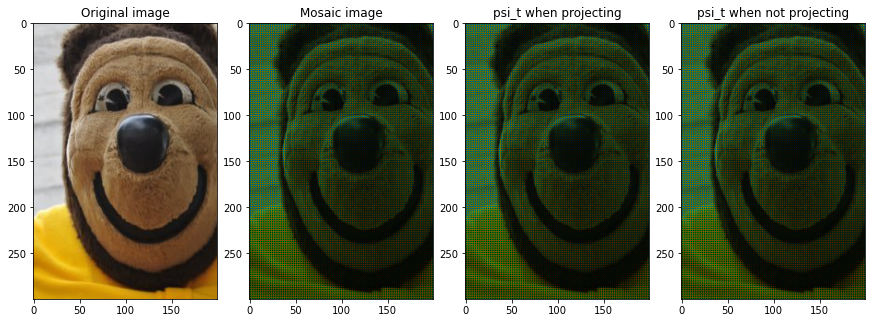

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), constrained_layout=True)
axes[0].imshow(image)
axes[1].imshow(mosaic_image)
axes[2].imshow(Psi_t_proj)
axes[3].imshow(Psi_t_unproj)

axes[0].set_title('Original image')
axes[1].set_title('Mosaic image')
axes[2].set_title('psi_t when projecting')
axes[3].set_title('psi_t when not projecting')

plt.show()

$\lambda = 2$

In [19]:
psi_t_proj, Psi_t_proj, mu_proj, q_proj = heuristic(mosaic_image, bayer_filter, proj=True, lpar=2)
psi_t_unproj, Psi_t_unproj, mu_unproj, q_unproj = heuristic(mosaic_image, bayer_filter, proj=False, lpar=2)

C:\Users\Wenhao\AppData\Local\Temp\ipykernel_27608\303717970.py:77: RuntimeWarning: invalid value encountered in true_divide
  mu_t = np.min((p_t / q_t)[q_t > 0])


In [22]:
print(mu_proj[:10], q_proj[:10])

[0.0019607844296842813, 0.0019607844296842813, 0.0019607841968536377, 0.001960784662514925, 0.0019607841968536377, 0.0019607841968536377, 0.0019607841968536377, 0.0019607851281762123, 0.0019607841968536377, 0.0019607841968536377] [array([ 2.,  2.,  2., ...,  2.,  2.,  2.]), array([ 2.,  2.,  2., ...,  2.,  2.,  2.]), array([ 2.,  2.,  2., ...,  2.,  2.,  0.]), array([ 2.,  2.,  2., ...,  2.,  2.,  0.]), array([ 2.,  2.,  2., ...,  0.,  2.,  0.]), array([ 2.,  2.,  2., ...,  0.,  2.,  0.]), array([ 2.,  2.,  2., ...,  0.,  2.,  0.]), array([ 2.,  2.,  2., ...,  0.,  2.,  0.]), array([ 2.,  2.,  2., ...,  0.,  2.,  0.]), array([ 2.,  2.,  2., ...,  0.,  2.,  0.])]


In [23]:
len(mu_proj)

255

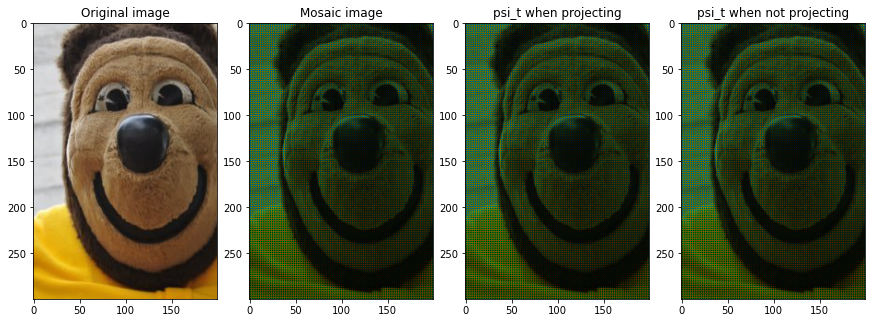

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), constrained_layout=True)
axes[0].imshow(image)
axes[1].imshow(mosaic_image)
axes[2].imshow(Psi_t_proj)
axes[3].imshow(Psi_t_unproj)

axes[0].set_title('Original image')
axes[1].set_title('Mosaic image')
axes[2].set_title('psi_t when projecting')
axes[3].set_title('psi_t when not projecting')

plt.show()

**Observation:** Two different $\lambda$'s but the same $\mu$'s. 

$\lambda = 100$

In [24]:
psi_t_proj, Psi_t_proj, mu_proj, q_proj = heuristic(mosaic_image, bayer_filter, proj=True, lpar=100)
psi_t_unproj, Psi_t_unproj, mu_unproj, q_unproj = heuristic(mosaic_image, bayer_filter, proj=False, lpar=100)

C:\Users\Wenhao\AppData\Local\Temp\ipykernel_27608\303717970.py:77: RuntimeWarning: invalid value encountered in true_divide
  mu_t = np.min((p_t / q_t)[q_t > 0])


In [25]:
print(mu_proj[:10], q_proj[:10])

[3.9215688593685628e-05, 3.9215688593685628e-05, 3.9215683937072751e-05, 3.9215693250298499e-05, 3.9215683937072751e-05, 3.9215683937072751e-05, 3.9215683937072751e-05, 3.9215702563524247e-05, 3.9215683937072751e-05, 3.9215683937072751e-05] [array([ 100.,  100.,  100., ...,  100.,  100.,  100.]), array([ 100.,  100.,  100., ...,  100.,  100.,  100.]), array([ 100.,  100.,  100., ...,  100.,  100.,    0.]), array([ 100.,  100.,  100., ...,  100.,  100.,    0.]), array([ 100.,  100.,  100., ...,    0.,  100.,    0.]), array([ 100.,  100.,  100., ...,    0.,  100.,    0.]), array([ 100.,  100.,  100., ...,    0.,  100.,    0.]), array([ 100.,  100.,  100., ...,    0.,  100.,    0.]), array([ 100.,  100.,  100., ...,    0.,  100.,    0.]), array([ 100.,  100.,  100., ...,    0.,  100.,    0.])]


In [26]:
len(mu_proj)

255

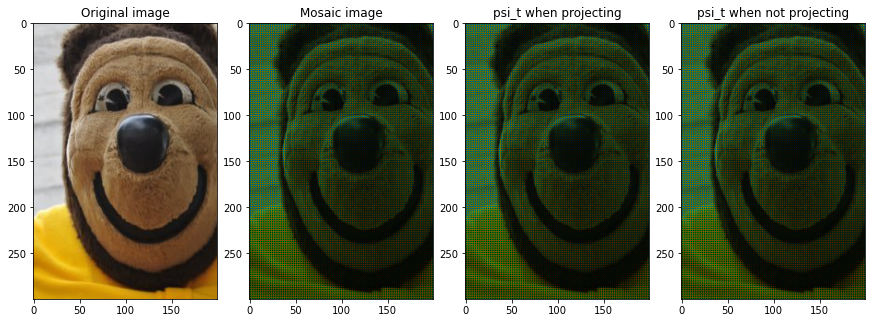

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), constrained_layout=True)
axes[0].imshow(image)
axes[1].imshow(mosaic_image)
axes[2].imshow(Psi_t_proj)
axes[3].imshow(Psi_t_unproj)

axes[0].set_title('Original image')
axes[1].set_title('Mosaic image')
axes[2].set_title('psi_t when projecting')
axes[3].set_title('psi_t when not projecting')

plt.show()

$\lambda = 1000$

In [28]:
psi_t_proj, Psi_t_proj, mu_proj, q_proj = heuristic(mosaic_image, bayer_filter, proj=True, lpar=1000)
psi_t_unproj, Psi_t_unproj, mu_unproj, q_unproj = heuristic(mosaic_image, bayer_filter, proj=False, lpar=1000)

C:\Users\Wenhao\AppData\Local\Temp\ipykernel_27608\303717970.py:77: RuntimeWarning: invalid value encountered in true_divide
  mu_t = np.min((p_t / q_t)[q_t > 0])


In [29]:
print(mu_proj[:10], q_proj[:10])

[3.9215688593685623e-06, 3.9215688593685623e-06, 3.9215683937072758e-06, 3.9215693250298497e-06, 3.9215683937072758e-06, 3.9215683937072758e-06, 3.9215683937072758e-06, 3.9215702563524245e-06, 3.9215683937072758e-06, 3.9215683937072758e-06] [array([ 1000.,  1000.,  1000., ...,  1000.,  1000.,  1000.]), array([ 1000.,  1000.,  1000., ...,  1000.,  1000.,  1000.]), array([ 1000.,  1000.,  1000., ...,  1000.,  1000.,     0.]), array([ 1000.,  1000.,  1000., ...,  1000.,  1000.,     0.]), array([ 1000.,  1000.,  1000., ...,     0.,  1000.,     0.]), array([ 1000.,  1000.,  1000., ...,     0.,  1000.,     0.]), array([ 1000.,  1000.,  1000., ...,     0.,  1000.,     0.]), array([ 1000.,  1000.,  1000., ...,     0.,  1000.,     0.]), array([ 1000.,  1000.,  1000., ...,     0.,  1000.,     0.]), array([ 1000.,  1000.,  1000., ...,     0.,  1000.,     0.])]


In [30]:
len(mu_proj)

255

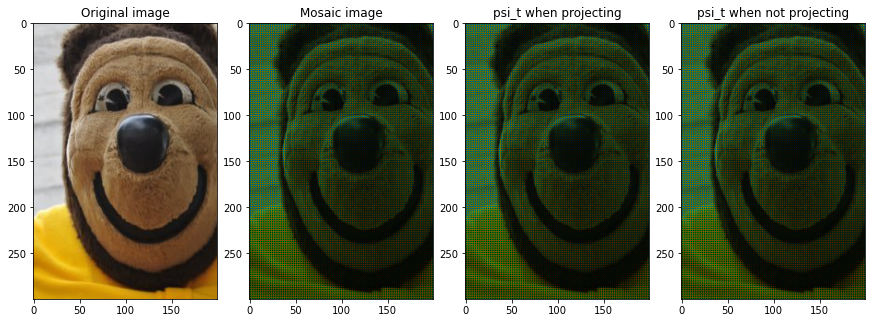

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), constrained_layout=True)
axes[0].imshow(image)
axes[1].imshow(mosaic_image)
axes[2].imshow(Psi_t_proj)
axes[3].imshow(Psi_t_unproj)

axes[0].set_title('Original image')
axes[1].set_title('Mosaic image')
axes[2].set_title('psi_t when projecting')
axes[3].set_title('psi_t when not projecting')

plt.show()